# Impute missing values for temperature and visits
Method for small gaps: fill forward (LOCF)\
Method for big gaps: STL and KNN 

In [2]:
import matplotlib.pyplot as plt

In [3]:
from load_building_data import load_building_data
data = load_building_data('bikuben')
bikuben = data['bikuben']

bikuben.rename(columns={'adjusted_visits_raw': 'Visits'}, inplace=True)
#bikuben.columns

#### Fill repeated sequences in temperature with NA 

In [5]:
df_imputed = bikuben.bfill()
from find_repeated_sequences import find_repeated_sequences

# Call find repeated sequences
repeated_sequences_temperature = find_repeated_sequences(df_imputed['Utetemperatur'], min_repeats=5)

repeated_sequences_visits = find_repeated_sequences(df_imputed['Visits'], min_repeats=25)


for start, end in repeated_sequences_temperature:
    df_imputed.loc[df_imputed.index[start:end+1], 'Utetemperatur'] = None
    
for start, end in repeated_sequences_visits:
    df_imputed.loc[df_imputed.index[start:end+1], 'Visits'] = None

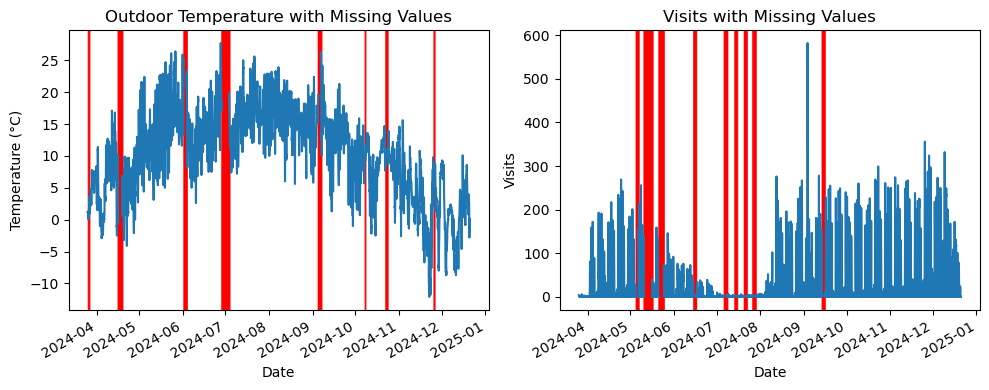

In [6]:
plt.figure(figsize=(10, 4))

# Temperature plot
plt.subplot(1, 2, 1)
ax1 = df_imputed['Utetemperatur'].plot(style='-', color='tab:blue', label='Temperature')
temp_missing = df_imputed[df_imputed['Utetemperatur'].isna()].index
for idx in temp_missing:
    plt.axvspan(idx, idx, color='red', alpha=0.5)
plt.title('Outdoor Temperature with Missing Values')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')

# Visits plot
plt.subplot(1, 2, 2)
ax2 = df_imputed['Visits'].plot(style='-', color='tab:blue', label='Visits')
visits_missing = df_imputed[df_imputed['Visits'].isna()].index
for idx in visits_missing:
    plt.axvspan(idx, idx, color='red', alpha=0.5)
plt.title('Visits with Missing Values')
plt.ylabel('Visits')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

#### STL imputation on temperature

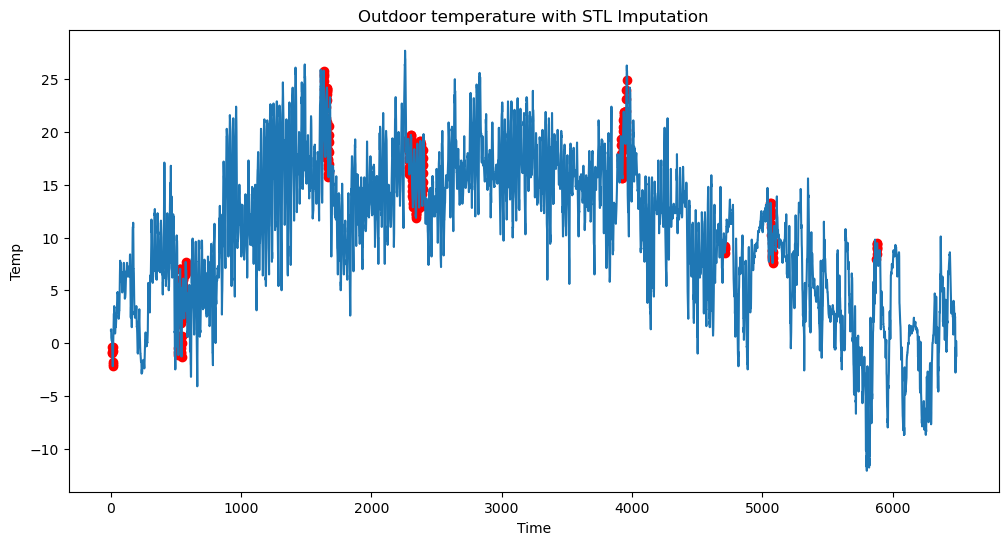

In [8]:
from statsmodels.tsa.seasonal import STL

df_copy = df_imputed.copy()
df_copy = df_copy.reset_index(drop=True)

imputed_indices = df_copy[df_copy['Utetemperatur'].isnull()].index

# Apply STL decompostion
stl = STL(df_copy['Utetemperatur'].interpolate(), seasonal=31, period=24*24)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['Utetemperatur'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
df = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'Utetemperatur'] = df[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['Utetemperatur'].plot(style='-',  label='temp')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'Utetemperatur'], color='red')

plt.title("Outdoor temperature with STL Imputation")
plt.ylabel("Temp")
plt.xlabel("Time")
plt.show()

In [9]:
df_copy.isnull().sum()

Fjernvarme              0
Nærkjøling              0
El                      0
Utetemperatur           0
Number_of_Bookings      0
Visits                477
dtype: int64

#### STL imputation on visits

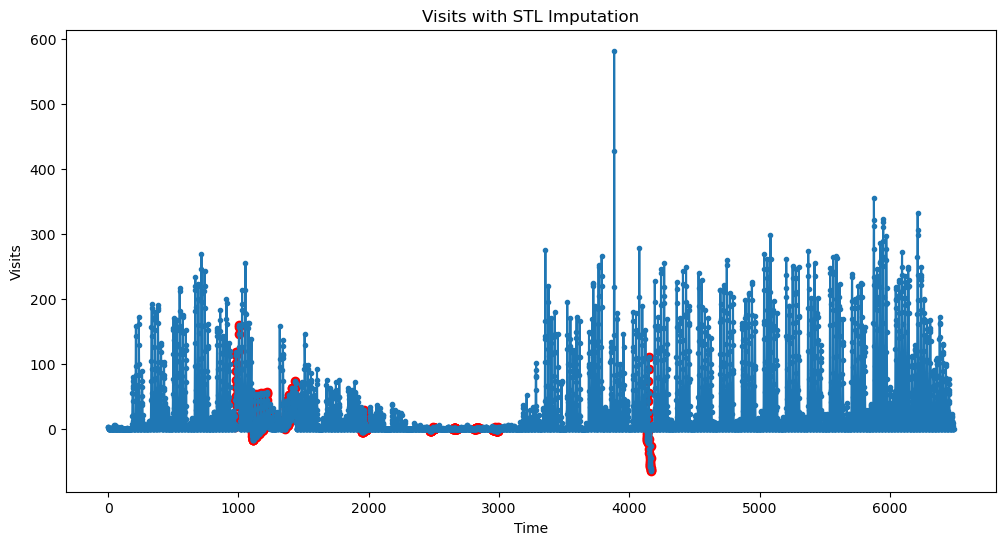

In [11]:
# Fill missing values in the time series
imputed_indices = df_copy[df_copy['Visits'].isnull()].index
# Apply STL decompostion
stl = STL(df_copy['Visits'].interpolate(), seasonal=31, period=24)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['Visits'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
df = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'Visits'] = df[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['Visits'].plot(style='.-',  label='Visits')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'Visits'], color='red')

plt.title("Visits with STL Imputation")
plt.ylabel("Visits")
plt.xlabel("Time")
plt.show()

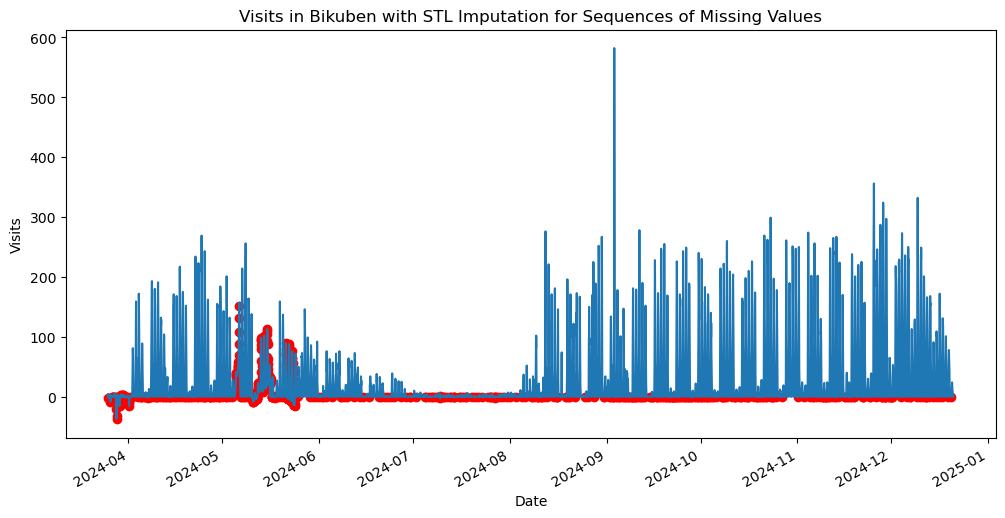

In [12]:
#%% Impute the bigger gaps with Seasonal Trend Decomposition using Loess (STL)
from statsmodels.tsa.seasonal import STL

# Make a copy of the original dataframe
df_copy = bikuben.copy()

# Fill missing values in the time series
imputed_indices = bikuben[bikuben['Visits'].isnull()].index

# Apply STL decompostion
stl = STL(df_copy['Visits'].interpolate(), seasonal=31, period=24*7)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['Visits'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
df = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'Visits'] = df[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['Visits'].plot(style='-',  label='Visits')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'Visits'], color='red')

plt.title("Visits in Bikuben with STL Imputation for Sequences of Missing Values")
plt.ylabel("Visits")
plt.xlabel("Date")
plt.show()

#### KNN imputation on temperature

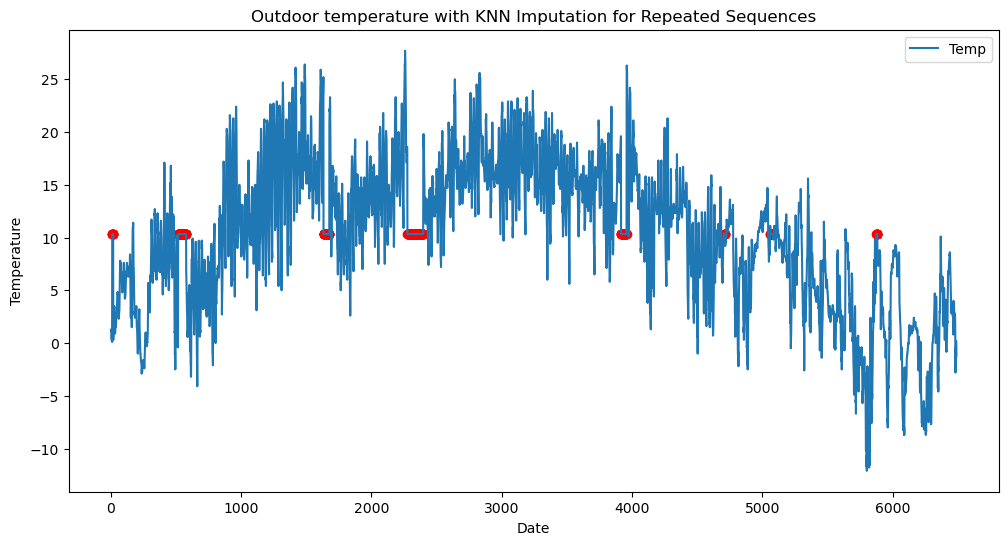

In [14]:
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

df_copy = df_imputed.copy()
df_copy = df_copy.reset_index(drop=True)

imputed_indices = df_copy[df_copy['Utetemperatur'].isnull()].index

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_copy[['Utetemperatur']] = imputer.fit_transform(df_copy[['Utetemperatur']])

# Plot
plt.figure(figsize=[12, 6])
df_copy['Utetemperatur'].plot(style='-', label='Temp')

# Highlight the imputed sequences
for start_idx, end_idx in repeated_sequences_temperature:
    plt.scatter(df_copy.index[start_idx:end_idx + 1], df_copy['Utetemperatur'].iloc[start_idx:end_idx + 1], color='red')

plt.title("Outdoor temperature with KNN Imputation for Repeated Sequences")
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.legend()
plt.show()


In [15]:
df_copy.isnull().sum()

Fjernvarme              0
Nærkjøling              0
El                      0
Utetemperatur           0
Number_of_Bookings      0
Visits                477
dtype: int64

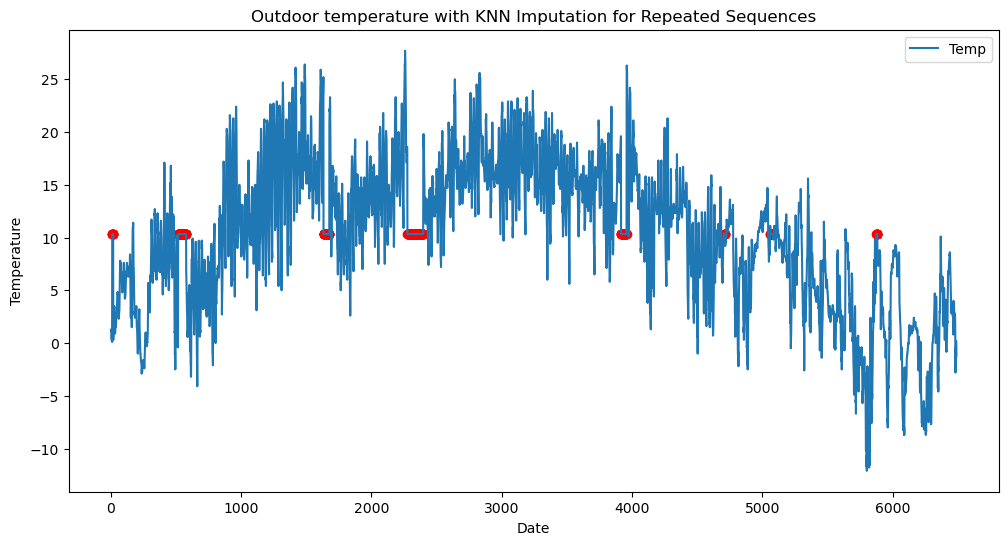

In [16]:
imputer = KNNImputer(n_neighbors=10)

# Iterate through the repeated_sequences list
for start_idx, end_idx in repeated_sequences_temperature:
    # Extract the subset of the series for the current sequence
    subset = df_copy['Utetemperatur'].iloc[start_idx:end_idx + 1].values.reshape(-1, 1)
    
    # Apply KNN imputation to the subset
    subset_imputed = imputer.fit_transform(subset)
    
    # Update the original dataframe with the imputed values for this sequence
    df_copy.iloc[start_idx:end_idx + 1, df_copy.columns.get_loc('Utetemperatur')] = subset_imputed.flatten()

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['Utetemperatur'].plot(style='-', label='Temp')

# Highlight the imputed sequences
for start_idx, end_idx in repeated_sequences_temperature:
    plt.scatter(df_copy.index[start_idx:end_idx + 1], df_copy['Utetemperatur'].iloc[start_idx:end_idx + 1], color='red')

plt.title("Outdoor temperature with KNN Imputation for Repeated Sequences")
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.legend()
plt.show()

#### KNN imputation on visits

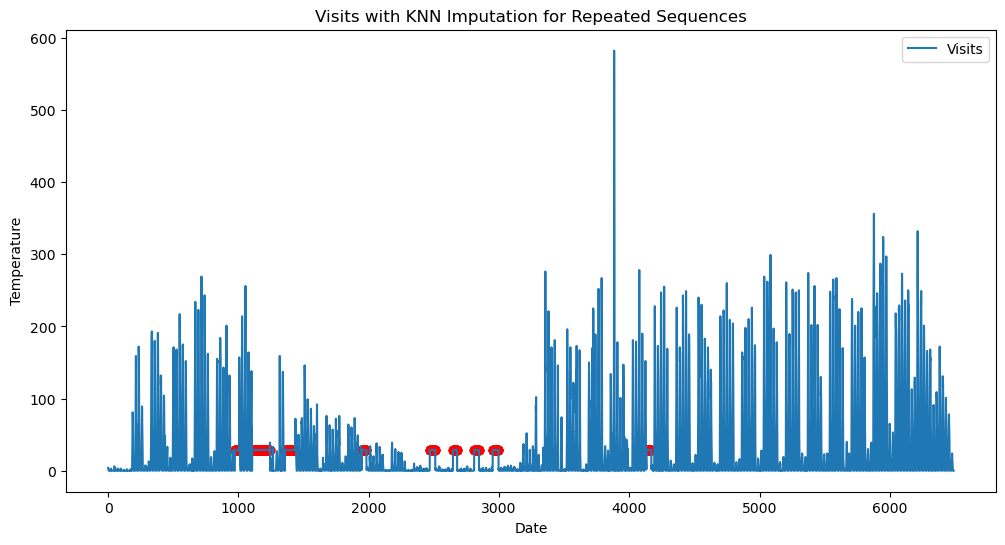

In [18]:
#imputed_indices = df_copy[df_copy['Visits'].isnull()].index

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=50)
df_copy[['Visits']] = imputer.fit_transform(df_copy[['Visits']])

# Plot
plt.figure(figsize=[12, 6])
df_copy['Visits'].plot(style='-', label='Visits')

# Highlight the imputed sequences
for start_idx, end_idx in repeated_sequences_visits:
    plt.scatter(df_copy.index[start_idx:end_idx + 1], df_copy['Visits'].iloc[start_idx:end_idx + 1], color='red')

plt.title("Visits with KNN Imputation for Repeated Sequences")
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.legend()
plt.show()


In [19]:
df_copy.isnull().sum()

Fjernvarme            0
Nærkjøling            0
El                    0
Utetemperatur         0
Number_of_Bookings    0
Visits                0
dtype: int64